<a href="https://colab.research.google.com/github/Mohamad-Alshalabi/Coursera_Capstone/blob/master/Final%20(The%20battle%20of%20neighborhoods).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#**THE BATTLE OF NEIGHBORHOODS**



#**Introduction**



Stockholm is the capital and most populous urban area of Sweden as well as in Scandinavia. Around 1 million people live in the municipality, approximately 1.6 million in the urban area, and 2.4 million in the metropolitan area. The city stretches across fourteen islands and it's one of the five fastest-growing cities in Europe.


Geographically, Stockholm city area only covers 188 squared kilometers; the area stretches to 6,519 squared kilometers for the metropolitan area. The disparity between the city center's density and the metropolitan area is more than ten folds, where the density within the city center is 5200 per sqr/km, the density in the metropolitan area is only 370 per sqr/km.
There are more than 3000 restaurants in Stockholm. The biggest food retailers in Sweden collectively have around 460 stores in Stockholm.



##**Problem**


The food supply in Stockholm metropolitan area concentrates mainly within the center, while the peripheries have less coverage. Opening a new food venue might be more profitable if the new establishments locate in areas with higher food demand. To tackle this problem we need to estimate the food demand in each neighborhood.
1.	Define Stockholm's neighborhoods
2.	Estimate the food demand in each neighborhood 




#**Target market** 


This study can benefit both food retailers and new investors in the food and beverage market in Stockholm, pointing out the regions with the least food coverage can open the path for various investment opportunities.  

#**Data**

**The data is obtained from various sources. The issue of data availability is overcome by creating our own sources.** 
  
To answer the question of which neighborhood in Stockholm has the least coverage of food venues, we should look into two main variables: the number of venues in each neighborhood. The Second variable is concerning the number of inhabitants in the neighborhood. 
In the list below I include the three source of data used in this study.     
1. The name and the postal code for each neighborhood collected and scrapped from the following website: https://worldpostalcode.com
2. The Latitude, the Longitude and the Population for each neighborhood in stockholm manually collected and gathered in one CSV file.
3. Name, location, latitude, longitude for each food venue in the neighborhoods collected from https://api.foursquare.com website. 


In [ ]:
!pip install geocoder
!pip install folium
import numpy as np 
import pandas as pd 
import geocoder 
import requests 
from requests import get 
from bs4 import BeautifulSoup 
import matplotlib.cm as cm
import matplotlib.colors as colors
from sklearn.cluster import KMeans
import folium 
from geopy.geocoders import Nominatim
from pandas.io.json import json_normalize
print("Importing is done")

Importing is done


In [ ]:
url = "https://worldpostalcode.com/sweden/stockholm/"
response = get(url)
html_soup = BeautifulSoup(response.text, 'html.parser')
type(html_soup)

bs4.BeautifulSoup

In [ ]:
Stockholm_containers = html_soup.find_all('div', class_ = 'container')
print(type(Stockholm_containers))
print(len(Stockholm_containers))

<class 'bs4.element.ResultSet'>
64


In [ ]:
names = []
for container in Stockholm_containers:
    if container.find('div') is not None:
        name = container.div.text
    names.append(name)

In [ ]:
Stockholm_codes = html_soup.find_all( class_ = 'code')
codes = []
for code in Stockholm_codes :
    i = Stockholm_codes.index(code)
    code = str(code)
    code = code.replace('<div class="code"><span>', '')
    code = code.replace('</span></div>', '')    
    code = code.split('</span> <span>') 
    codes.append(code)

In [ ]:
data = {'Neighborhood': names, 'Postal_Code': codes}
Data= pd.DataFrame(data= data, columns= ['Neighborhood','Postal_Code'])

In [ ]:
Stockholm_data = pd.read_csv("https://raw.githubusercontent.com/Mohamad-Alshalabi/Coursera_Capstone/master/Book2.csv")

Stockholm_data.head()

,Neighborhood,Latitude,Longitude,Population
0,Akersberga,59.4803,18.3108,28033
1,Alta,59.2555,18.1781,9989
2,Alvsjo,59.2745,18.0051,1530
3,Arsta,59.2986,18.0459,16807
4,Bagarmossen,59.2744,18.1338,10915


In [ ]:
Stockholm_geo_data = pd.merge(Stockholm_data, Data, on='Neighborhood')
Stockholm_geo_data.head()

,Neighborhood,Latitude,Longitude,Population,Postal_Code
0,Akersberga,59.4803,18.3108,28033,[184 20]
1,Alta,59.2555,18.1781,9989,[138 20]
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5..."
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5..."
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4..."


In [ ]:
print('The dataframe has {} neighborhoods.'.format( len(Stockholm_geo_data['Neighborhood'].unique())))

The dataframe has 64 neighborhoods.


In [ ]:
address = 'Stockholm Sweden'
geolocator = Nominatim(user_agent="stock_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of Stockholm are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of Stockholm are 59.3251172, 18.0710935.


In [ ]:
map_Stockholm = folium.Map(location=[latitude,longitude], zoom_start= 10)
for lat, lng, label in zip(Stockholm_geo_data['Latitude'], Stockholm_geo_data['Longitude'], Stockholm_geo_data['Neighborhood']):
    label = folium.Popup(label, parse_html= True)
    folium.CircleMarker(
        [lat,lng],
        radius=6,
        popup= label, 
        color= 'blue',
        fill= True,
        fill_color= 'FFFF5c', 
        fill_opacity= 0.7
        ).add_to(map_Stockholm)

map_Stockholm

In [ ]:
CLIENT_ID = 'CAH33GB3T5AA33ZLAPKRSPMN0HPJAF0CRI1ES31CMFKIMRT0' 
CLIENT_SECRET = 'Q1LRHG2SDJMSACGJGKA1K2CMDWGMPJQSN05CWAMEOOEFH0YL' 
VERSION = '20210217'

In [ ]:
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

In [ ]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
       
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
      
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [ ]:
Stockholm_venues = getNearbyVenues(names=Stockholm_geo_data['Neighborhood'],
                                   latitudes=Stockholm_geo_data['Latitude'],
                                   longitudes=Stockholm_geo_data['Longitude'],
                                  )

Akersberga
Alta
Alvsjo
Arsta
Bagarmossen
Bandhagen
Bro
Bromma
Danderyd
Ekero
Enskede
Enskede Gard
Enskededalen
Farsta
Gustavsberg
Hagersten
Hallstavik
Handen
Haninge
Hasselby
Huddinge
Jarfalla
Jarna
Johanneshov
Kista
Kungsangen
Lidingo
Marsta
Nacka
Norrtalje
Norsborg
Nykvarn
Nynashamn
Osmo
Rimbo
Ronninge
Rosersberg
Saltsjo-Boo
Saltsjobaden
Sigtuna
Skarholmen
Skarpnack
Skogas
Skondal
Sodertalje
Sollentuna
Solna
Spanga
Stockholm
Stockholm-Arlanda
Stockholm-Globen
Sundbyberg
Taby
Tomteboda
Tullinge
Tumba
Tyreso
Upplands Vasby
Vallentuna
Vallingby
Varby
Varmdo
Vasterhaninge
Vaxholm


In [ ]:
Stockholm_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akersberga,4,4,4,4,4,4
Alta,7,7,7,7,7,7
Alvsjo,12,12,12,12,12,12
Arsta,12,12,12,12,12,12
Bagarmossen,9,9,9,9,9,9
...,...,...,...,...,...,...
Vallentuna,8,8,8,8,8,8
Vallingby,12,12,12,12,12,12
Varby,4,4,4,4,4,4


In [ ]:
Stockholm_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akersberga,4,4,4,4,4,4
Alta,7,7,7,7,7,7
Alvsjo,12,12,12,12,12,12
Arsta,12,12,12,12,12,12
Bagarmossen,9,9,9,9,9,9
...,...,...,...,...,...,...
Vallentuna,8,8,8,8,8,8
Vallingby,12,12,12,12,12,12
Varby,4,4,4,4,4,4


In [ ]:
print('There are {} uniques categories.'.format(len(Stockholm_venues['Venue Category'].unique())))

There are 156 uniques categories.


In [ ]:
Stockholm_onehot = pd.get_dummies(Stockholm_venues[['Venue Category']], prefix="", prefix_sep="")
Stockholm_onehot['Neighborhood'] = Stockholm_venues['Neighborhood'] 
fixed_columns = [Stockholm_onehot.columns[-1]] + list(Stockholm_onehot.columns[:-1])
Stockholm_onehot = Stockholm_onehot[fixed_columns]
Stockholm_onehot.head()

,Neighborhood,Airport,Airport Lounge,Airport Service,American Restaurant,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Automotive Shop,Bagel Shop,Bakery,Bar,Beach,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Currency Exchange,Department Store,Dim Sum Restaurant,...,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Soccer Field,South Indian Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Video Store,Vietnamese Restaurant,Women's Store
0,Akersberga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,Akersberga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,Akersberga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,Akersberga,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,Alta,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
Stockholm_onehot.shape

(659, 157)

In [ ]:
Stockholm_grouped = Stockholm_onehot.groupby('Neighborhood').mean().reset_index()
Stockholm_grouped

,Neighborhood,Airport,Airport Lounge,Airport Service,American Restaurant,Arts & Crafts Store,Asian Restaurant,Assisted Living,Athletics & Sports,Automotive Shop,Bagel Shop,Bakery,Bar,Beach,Boat or Ferry,Bookstore,Bowling Alley,Breakfast Spot,Burger Joint,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Camera Store,Candy Store,Chinese Restaurant,Chocolate Shop,Climbing Gym,Clothing Store,Coffee Shop,Community Center,Construction & Landscaping,Convenience Store,Cosmetics Shop,Currency Exchange,Department Store,Dim Sum Restaurant,...,Pizza Place,Playground,Plaza,Pool,Pub,Record Shop,Restaurant,Salad Place,Sandwich Place,Scandinavian Restaurant,Scenic Lookout,Seafood Restaurant,Shoe Store,Shopping Mall,Shopping Plaza,Skating Rink,Ski Area,Soccer Field,South Indian Restaurant,Sporting Goods Shop,Sports Bar,Stables,Stadium,Supermarket,Sushi Restaurant,Taco Place,Tapas Restaurant,Tennis Court,Tennis Stadium,Thai Restaurant,Theater,Thrift / Vintage Store,Toy / Game Store,Track Stadium,Trail,Train Station,Turkish Restaurant,Video Store,Vietnamese Restaurant,Women's Store
0,Akersberga,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.25,0.0,0.25,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.250000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Alta,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.142857,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.142857,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.142857,0.0,0.00,0.0,0.142857,0.0,0.0,0.0,0.0,0.142857,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Alvsjo,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.083333,0.000000,0.000000,0.000000,0.0,0.0,0.083333,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.083333,0.0,0.0,0.0,0.0,0.000000,0.083333,0.000000,0.0,0.0,0.0,0.083333,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Arsta,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.083333,0.0,0.0,0.0,0.0,...,0.083333,0.000000,0.083333,0.000000,0.0,0.0,0.083333,0.0,0.0,0.083333,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Bagarmossen,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.111111,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.111111,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.111111,0.111111,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
57,Vallentuna,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.0,0.00,0.000000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.125000,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.125000,0.000000,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.00,0.0,0.000000,0.0,0.0,0.0,0.0,0.000000,0.125000,0.125000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.

In [ ]:
num_top_venues = 5

for hood in Stockholm_grouped['Neighborhood']:
    print("----"+hood+"----")
    temp = Stockholm_grouped[Stockholm_grouped['Neighborhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Akersberga----
                  venue  freq
0           Pizza Place  0.25
1           Bus Station  0.25
2          Burger Joint  0.25
3  Gym / Fitness Center  0.25
4           Music Venue  0.00


----Alta----
           venue  freq
0   Soccer Field  0.14
1       Bus Stop  0.14
2        Stadium  0.14
3   Hockey Arena  0.14
4  Grocery Store  0.14


----Alvsjo----
               venue  freq
0              Hotel  0.17
1       Soccer Field  0.08
2           Gym Pool  0.08
3        Pizza Place  0.08
4  Indian Restaurant  0.08


----Arsta----
              venue  freq
0       Pizza Place  0.08
1        Restaurant  0.08
2  Greek Restaurant  0.08
3     Grocery Store  0.08
4            Forest  0.08


----Bagarmossen----
                  venue  freq
0                 Plaza  0.11
1                Bakery  0.11
2  Fast Food Restaurant  0.11
3                  Café  0.11
4         Grocery Store  0.11


----Bandhagen----
              venue  freq
0       Pizza Place  0.17
1       Bus Station  0.

In [ ]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

In [ ]:
num_top_venues = 10
indicators = ['st', 'nd', 'rd']
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = Stockholm_grouped['Neighborhood']

for ind in np.arange(Stockholm_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(Stockholm_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(20)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,Pizza Place,Gym / Fitness Center,Burger Joint,Bus Station,History Museum,Historic Site,Forest,Food Truck,Food Court,Food & Drink Shop
1,Alta,Hockey Arena,Soccer Field,Shopping Mall,Stadium,Grocery Store,Bus Stop,Convenience Store,Entertainment Service,Event Space,Falafel Restaurant
2,Alvsjo,Hotel,Gym Pool,Soccer Field,Restaurant,Supermarket,Grocery Store,Tennis Stadium,Gym / Fitness Center,Bakery,Indian Restaurant
3,Arsta,Grocery Store,Forest,Pizza Place,Asian Restaurant,Convenience Store,Plaza,Scandinavian Restaurant,Light Rail Station,Café,Kebab Restaurant
4,Bagarmossen,Pharmacy,Fast Food Restaurant,Café,Supermarket,Sushi Restaurant,Grocery Store,Bakery,Plaza,Metro Station,Event Space
5,Bandhagen,Bus Station,Pizza Place,Mediterranean Restaurant,Metro Station,Café,Stadium,Sushi Restaurant,Hobby Shop,Playground,Grocery Store
6,Bro,Pizza Place,Gym Pool,Train Station,Grocery Store,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market
7,Bromma,Supermarket,Liquor Store,Pub,Sushi Restaurant,Chinese Restaurant,Tennis Court,Bus Stop,Bakery,Farm,Fast Food Restaurant
8,Danderyd,Pizza Place,Pool,Fast Food Restaurant,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market
9,Ekero,Pizza Place,Gym / Fitness Center,Convenience Store,Stadium,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


In [ ]:
Stockholm_grouped_clustring= Stockholm_grouped.drop('Neighborhood', 1)
Sum_of_squared_distances = []
K = range(1,40)
for k in K:
    km = KMeans(n_clusters=k)
    km = km.fit(Stockholm_grouped_clustring)
    Sum_of_squared_distances.append(km.inertia_)

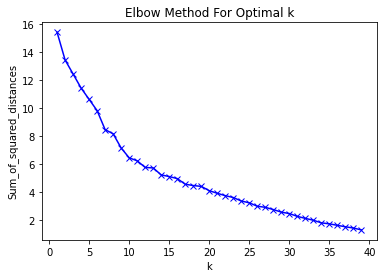

In [ ]:
import matplotlib.pyplot as plt
plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [ ]:

kclusters = 8
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(Stockholm_grouped_clustring)
kmeans.labels_[0:10]

array([1, 3, 3, 3, 3, 1, 1, 3, 1, 1], dtype=int32)

In [ ]:
neighborhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

Stockholm_merged = Stockholm_geo_data

Stockholm_merged = Stockholm_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')
Stockholm_merged.drop([16], inplace=True)
Stockholm_merged.reset_index()

Stockholm_merged

,Neighborhood,Latitude,Longitude,Population,Postal_Code,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,59.4803,18.3108,28033,[184 20],1.0,Pizza Place,Gym / Fitness Center,Burger Joint,Bus Station,History Museum,Historic Site,Forest,Food Truck,Food Court,Food & Drink Shop
1,Alta,59.2555,18.1781,9989,[138 20],3.0,Hockey Arena,Soccer Field,Shopping Mall,Stadium,Grocery Store,Bus Stop,Convenience Store,Entertainment Service,Event Space,Falafel Restaurant
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5...",3.0,Hotel,Gym Pool,Soccer Field,Restaurant,Supermarket,Grocery Store,Tennis Stadium,Gym / Fitness Center,Bakery,Indian Restaurant
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5...",3.0,Grocery Store,Forest,Pizza Place,Asian Restaurant,Convenience Store,Plaza,Scandinavian Restaurant,Light Rail Station,Café,Kebab Restaurant
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4...",3.0,Pharmacy,Fast Food Restaurant,Café,Supermarket,Sushi Restaurant,Grocery Store,Bakery,Plaza,Metro Station,Event Space
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
59,Vallingby,59.3671,17.8691,82500,"[162 00, 162 60, 162 01, 162 88, 162 83, 162 7...",3.0,Gym / Fitness Center,Pharmacy,Pool,Café,Supermarket,Moving Target,Business Service,Theater,Grocery Store,Playground
60,Varby,59.2635,17.8876,10727,"[143 46, 143 20]",1.0,Pizza Place,Grocery Store,Gym Pool,Metro Station,Electronics Store,Fountain,Forest,Food Truck,Food Court,Food & Drink Shop
61,Varmdo,59.2846,18.5208,45393,"[139 00, 139 20, 139 31]",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
62,Vasterhaninge,59.1216,18.0973,15134,"[137 20, 137 42]",1.0,Train Station,Supermarket,Grocery Store,Fast Food Restaurant,Bus Station,Women's Store,Food,Fountain,Forest,Food Truck


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 0, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
36,Rosersberg,0.0,Construction & Landscaping,Women's Store,Fish Market,Fountain,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 1, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Akersberga,1.0,Pizza Place,Gym / Fitness Center,Burger Joint,Bus Station,History Museum,Historic Site,Forest,Food Truck,Food Court,Food & Drink Shop
5,Bandhagen,1.0,Bus Station,Pizza Place,Mediterranean Restaurant,Metro Station,Café,Stadium,Sushi Restaurant,Hobby Shop,Playground,Grocery Store
6,Bro,1.0,Pizza Place,Gym Pool,Train Station,Grocery Store,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market
8,Danderyd,1.0,Pizza Place,Pool,Fast Food Restaurant,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Fish Market
9,Ekero,1.0,Pizza Place,Gym / Fitness Center,Convenience Store,Stadium,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
10,Enskede,1.0,Bus Station,Automotive Shop,Entertainment Service,Dog Run,Hobby Shop,History Museum,Fountain,Forest,Food Truck,Food Court
12,Enskededalen,1.0,Playground,Indian Restaurant,Asian Restaurant,Grocery Store,Fast Food Restaurant,Women's Store,Flower Shop,Forest,Food Truck,Food Court
13,Farsta,1.0,Grocery Store,Pizza Place,Plaza,Bakery,Farm,Shopping Plaza,Convenience Store,Coffee Shop,Restaurant,Food & Drink Shop
26,Lidingo,1.0,Pizza Place,Sushi Restaurant,Thai Restaurant,Soccer Field,Women's Store,Fish Market,Forest,Food Truck,Food Court,Food & Drink Shop
31,Nykvarn,1.0,Food & Drink Shop,Train Station,Grocery Store,Tennis Court,Women's Store,Fish Market,Forest,Food Truck,Food Court,Food


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 2, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
14,Gustavsberg,2.0,Lake,Women's Store,Furniture / Home Store,Fountain,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop
20,Huddinge,2.0,Lake,Women's Store,Furniture / Home Store,Fountain,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 3, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
1,Alta,3.0,Hockey Arena,Soccer Field,Shopping Mall,Stadium,Grocery Store,Bus Stop,Convenience Store,Entertainment Service,Event Space,Falafel Restaurant
2,Alvsjo,3.0,Hotel,Gym Pool,Soccer Field,Restaurant,Supermarket,Grocery Store,Tennis Stadium,Gym / Fitness Center,Bakery,Indian Restaurant
3,Arsta,3.0,Grocery Store,Forest,Pizza Place,Asian Restaurant,Convenience Store,Plaza,Scandinavian Restaurant,Light Rail Station,Café,Kebab Restaurant
4,Bagarmossen,3.0,Pharmacy,Fast Food Restaurant,Café,Supermarket,Sushi Restaurant,Grocery Store,Bakery,Plaza,Metro Station,Event Space
7,Bromma,3.0,Supermarket,Liquor Store,Pub,Sushi Restaurant,Chinese Restaurant,Tennis Court,Bus Stop,Bakery,Farm,Fast Food Restaurant
11,Enskede Gard,3.0,Bakery,Restaurant,Stables,Light Rail Station,Metro Station,Event Space,Food & Drink Shop,Fountain,Forest,Duty-free Shop
17,Handen,3.0,Hotel,Electronics Store,Liquor Store,Shopping Mall,Coffee Shop,Thai Restaurant,Sandwich Place,Fish Market,Food Truck,Food Court
18,Haninge,3.0,Fast Food Restaurant,Department Store,Shoe Store,Supermarket,Coffee Shop,Thai Restaurant,Liquor Store,Café,Flower Shop,Clothing Store
19,Hasselby,3.0,Business Service,Scandinavian Restaurant,Metro Station,Playground,Pool,Event Space,Theater,Moving Target,Supermarket,Food & Drink Shop
22,Jarna,3.0,Hockey Rink,Supermarket,Music Venue,Thai Restaurant,Bakery,Women's Store,Fish Market,Forest,Food Truck,Food Court


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 4, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
21,Jarfalla,4.0,Burger Joint,Women's Store,Garden Center,French Restaurant,Fountain,Forest,Food Truck,Food Court,Food & Drink Shop,Food


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 5, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
15,Hagersten,5.0,Forest,Women's Store,Fish Market,Fountain,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Fast Food Restaurant


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 6, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
28,Nacka,6.0,Ski Area,Women's Store,Fish Market,Forest,Food Truck,Food Court,Food & Drink Shop,Food,Flower Shop,Fast Food Restaurant


In [ ]:
Stockholm_merged.loc[Stockholm_merged['Cluster Labels'] == 7, Stockholm_merged.columns[[0] + list(range(5, Stockholm_merged.shape[1]))]]

,Neighborhood,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
34,Rimbo,7.0,Café,Hockey Arena,Liquor Store,Women's Store,Flower Shop,Forest,Food Truck,Food Court,Food & Drink Shop,Food
53,Tomteboda,7.0,Café,Light Rail Station,Women's Store,Furniture / Home Store,Fountain,Forest,Food Truck,Food Court,Food & Drink Shop,Food


In [ ]:
def getNearbyVenues1(names, latitudes, longitudes, radius=500, categoryIds=''):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
       
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            100)
            
       
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
      
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)
                  

In [ ]:
Stockholm_food_venues = getNearbyVenues1(names=Stockholm_geo_data['Neighborhood'],
                                   latitudes=Stockholm_geo_data['Latitude'],
                                   longitudes=Stockholm_geo_data['Longitude'], radius=1000, categoryIds= '4d4b7105d754a06374d81259')

Akersberga
Alta
Alvsjo
Arsta
Bagarmossen
Bandhagen
Bro
Bromma
Danderyd
Ekero
Enskede
Enskede Gard
Enskededalen
Farsta
Gustavsberg
Hagersten
Hallstavik
Handen
Haninge
Hasselby
Huddinge
Jarfalla
Jarna
Johanneshov
Kista
Kungsangen
Lidingo
Marsta
Nacka
Norrtalje
Norsborg
Nykvarn
Nynashamn
Osmo
Rimbo
Ronninge
Rosersberg
Saltsjo-Boo
Saltsjobaden
Sigtuna
Skarholmen
Skarpnack
Skogas
Skondal
Sodertalje
Sollentuna
Solna
Spanga
Stockholm
Stockholm-Arlanda
Stockholm-Globen
Sundbyberg
Taby
Tomteboda
Tullinge
Tumba
Tyreso
Upplands Vasby
Vallentuna
Vallingby
Varby
Varmdo
Vasterhaninge
Vaxholm


In [ ]:
Stockholm_food_venues.head()

,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Akersberga,59.4803,18.3108,ICA Kvantum Åkersberga,59.479721,18.297570,Grocery Store
1,Akersberga,59.4803,18.3108,Berga Sushi,59.482627,18.302635,Sushi Restaurant
2,Akersberga,59.4803,18.3108,The Public,59.480178,18.298988,Gastropub
3,Akersberga,59.4803,18.3108,Åkersberga (L),59.479164,18.299074,Light Rail Station
4,Akersberga,59.4803,18.3108,Hackstahallen,59.482938,18.301924,Basketball Court


In [ ]:
Stockholm_food_venues.shape

(1299, 7)

In [ ]:
def addToMap(df, color, existingMap):
    for lat, lng, local, venue, venueCat in zip(df['Venue Latitude'], df['Venue Longitude'], df['Neighborhood'], df['Venue'], df['Venue Category']):
        label = '{} ({}) - {}'.format(venue, venueCat, local)
        label = folium.Popup(label, parse_html=True)
        folium.CircleMarker(
            [lat, lng],
            radius=5,
            popup=label,
            color=color,
            fill=True,
            fill_color=color,
            fill_opacity=0.7).add_to(existingMap)

In [ ]:
map_Stockholm_food_venues = folium.Map(location=[latitude, longitude], zoom_start=10)
addToMap(Stockholm_food_venues, 'red', map_Stockholm_food_venues)

map_Stockholm_food_venues

In [ ]:
Stockholm_grouped_1=  Stockholm_food_venues.groupby('Neighborhood').count()
Stockholm_grouped_1.head()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
Akersberga,10,10,10,10,10,10
Alta,12,12,12,12,12,12
Alvsjo,25,25,25,25,25,25
Arsta,35,35,35,35,35,35
Bagarmossen,19,19,19,19,19,19


In [ ]:
Stockholm_grouped_1.shape

(64, 6)

In [ ]:
Data_1= pd.DataFrame(data=Stockholm_grouped_1, columns=['Venue'] )
Data_1

,Venue
Neighborhood,
Akersberga,10
Alta,12
Alvsjo,25
Arsta,35
Bagarmossen,19
...,...
Vallingby,32
Varby,9
Varmdo,3


In [ ]:
Stockholm= pd.merge(Stockholm_geo_data , Data_1, on='Neighborhood')

In [ ]:
Stockholm

,Neighborhood,Latitude,Longitude,Population,Postal_Code,Venue
0,Akersberga,59.4803,18.3108,28033,[184 20],10
1,Alta,59.2555,18.1781,9989,[138 20],12
2,Alvsjo,59.2745,18.0051,1530,"[125 00, 125 58, 125 52, 125 53, 125 54, 125 5...",25
3,Arsta,59.2986,18.0459,16807,"[120 02, 120 52, 120 59, 120 58, 120 57, 120 5...",35
4,Bagarmossen,59.2744,18.1338,10915,"[128 04, 128 05, 128 41, 128 42, 128 43, 128 4...",19
...,...,...,...,...,...,...
59,Vallingby,59.3671,17.8691,82500,"[162 00, 162 60, 162 01, 162 88, 162 83, 162 7...",32
60,Varby,59.2635,17.8876,10727,"[143 46, 143 20]",9
61,Varmdo,59.2846,18.5208,45393,"[139 00, 139 20, 139 31]",3
62,Vasterhaninge,59.1216,18.0973,15134,"[137 20, 137 42]",13


In [ ]:
Stockholm_1=pd.DataFrame(data= Stockholm, columns= ['Neighborhood', 'Density'])
Stockholm_1

,Neighborhood,Density
0,Akersberga,NaN
1,Alta,NaN
2,Alvsjo,NaN
3,Arsta,NaN
4,Bagarmossen,NaN
...,...,...
59,Vallingby,NaN
60,Varby,NaN
61,Varmdo,NaN
62,Vasterhaninge,NaN


In [ ]:
Stockholm_1['Density']= Stockholm['Venue']/Stockholm['Population ']

In [ ]:
Stockholm_1.head()

,Neighborhood,Density
0,Akersberga,0.000357
1,Alta,0.001201
2,Alvsjo,0.016340
3,Arsta,0.002082
4,Bagarmossen,0.001741


In [ ]:
Stockholm_1[['Density']].idxmin()

Density    45
dtype: int64

In [ ]:
Stockholm_1.iloc[45]

Neighborhood    Sollentuna
Density         1.3523e-05
Name: 45, dtype: object

#*RESULTS*
Sollentuna has the least covrage of all neighborhoods, that indicates an opportunity for investment. 
  